## Data processing
### This file shows how to selected essential information in Integrated File.


## Part 1: Import Excel File 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
integrate_data=pd.read_excel('./DB_INTEGRATED_ENGLISH.xlsx')

In [4]:
integrate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20374 entries, 0 to 20373
Data columns (total 84 columns):
ID_CREDIT                      20374 non-null int64
COUNTRY                        20374 non-null object
ID_EVALUATION                  20374 non-null int64
NUMBER_OF_PAYMENTS             20374 non-null int64
REPORTED_PAYMENTS              20374 non-null int64
AMOUNT                         20374 non-null int64
MAXIMUM_CREDIT                 20374 non-null int64
CURRENT_BALANCE                20374 non-null int64
CREDIT_LIMIT                   20374 non-null int64
PENDING_BALANCE                20374 non-null int64
PAST_DUE_PAYMENTS              20374 non-null int64
WORST_PAST_DUE_BALANCE         20374 non-null int64
TIMES_PAST_DUE                 20374 non-null int64
OUTSTANDING_BALANCE            20374 non-null int64
AMOUNT_LAST_PAYMENT            20374 non-null int64
PLAZO_CREDITO_MESES            20374 non-null int64
AMOUNT_LOANED                  20374 non-null int64
GROUP_

## Part 2: Processing Data
## 2.1 Only select 'TYPE_OF_CUSTOMER2' = 'PF' data analze

In [17]:
data_person=integrate_data[integrate_data['TYPE_OF_CUSTOMER2']=='PF']

## 2.2 Choose past due payments as a factor determined good, fraud customers
### 2.2.1 If 'PAST_DUE_PAYMENTS' >0, customer is fraud, else customer is good.


In [6]:
def good_badcus(dataframe):
    good=[]
    fraud=[]
    for _, value in dataframe.items():
        if value==0:
            good.append(1)
            fraud.append(0)
        else:
            good.append(0)
            fraud.append(1)
    return good, fraud

### 2.2.2 Adding 'Good', 'Fraud' Factors into dataframe 'data_process'.

In [18]:
good, fraud=good_badcus(data_person.PAST_DUE_PAYMENTS)
data_person.insert(0, "Good", good, True)
data_person.insert(1, "Fraud", fraud, True)

## 2.3 Delay Times(TIMES_PAST_DUE) related to fraud
### 2.3.1 See the distribution of 'TIMES_PAST_DUE'

In [8]:
data_person.loc[data_person['Fraud'] == 1].TIMES_PAST_DUE.describe()

count    8107.000000
mean        9.775996
std        18.166157
min         0.000000
25%         1.000000
50%         3.000000
75%        11.000000
max        84.000000
Name: TIMES_PAST_DUE, dtype: float64

In [9]:
data_person.loc[data_person['Fraud'] == 1].groupby('TIMES_PAST_DUE')['Fraud'].count ()

TIMES_PAST_DUE
0       33
1     2948
2     1063
3      609
4      388
5      253
6      351
7      135
8      102
9       98
10      89
11      97
12      78
13     859
14      51
15      20
16      24
17      21
18      15
19      14
20      19
21      12
22      21
23      15
24      13
25      13
26      17
27      15
28       7
29      13
      ... 
52       9
53      10
54      16
55       9
56      12
57      11
58      13
59      16
60       4
61      10
62       7
64       6
65      11
66       7
67       7
68       9
69      12
71       8
72       8
73       7
74       9
75       3
76       2
77       2
78       9
79       7
81       2
82       2
83       3
84     248
Name: Fraud, Length: 82, dtype: int64

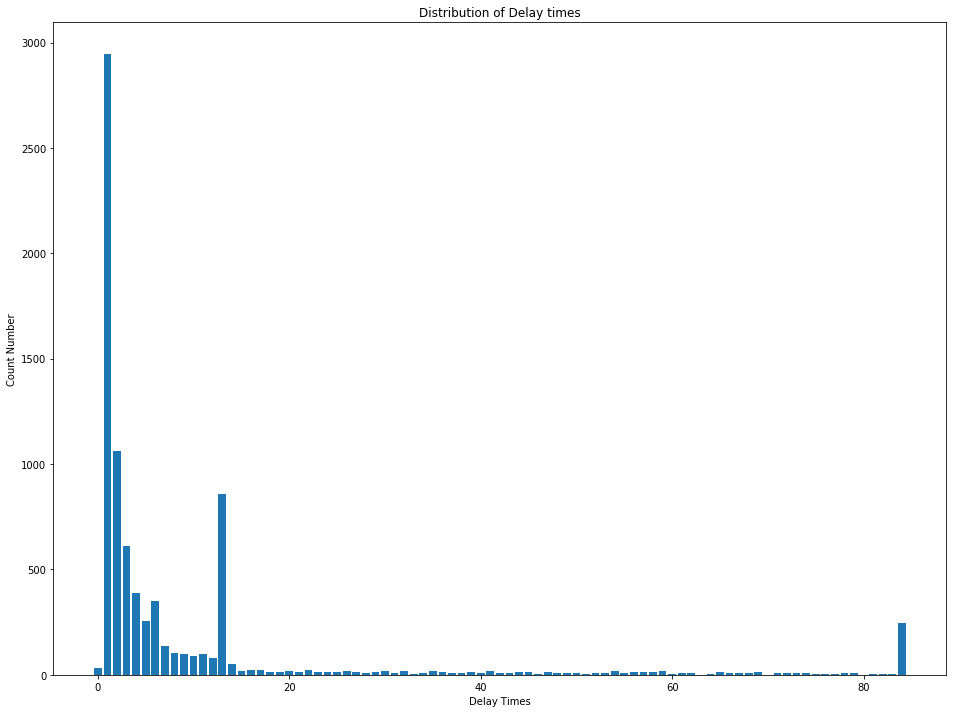

In [10]:
# Plot histogram of Delay times 
fig, ax = plt.subplots(figsize=(16, 12))
ax.bar(data_person.loc[data_person['Fraud'] == 1].groupby('TIMES_PAST_DUE')['Fraud'].count ().index,data_person.loc[data_person['Fraud'] == 1].groupby('TIMES_PAST_DUE')['Fraud'].count ())
ax.set_ylabel('Count Number')
ax.set_xlabel('Delay Times')
ax.set_title('Distribution of Delay times')
plt.show()

## 2.4 Delay Times(TIMES_PAST_DUE) related to Past Due Payments

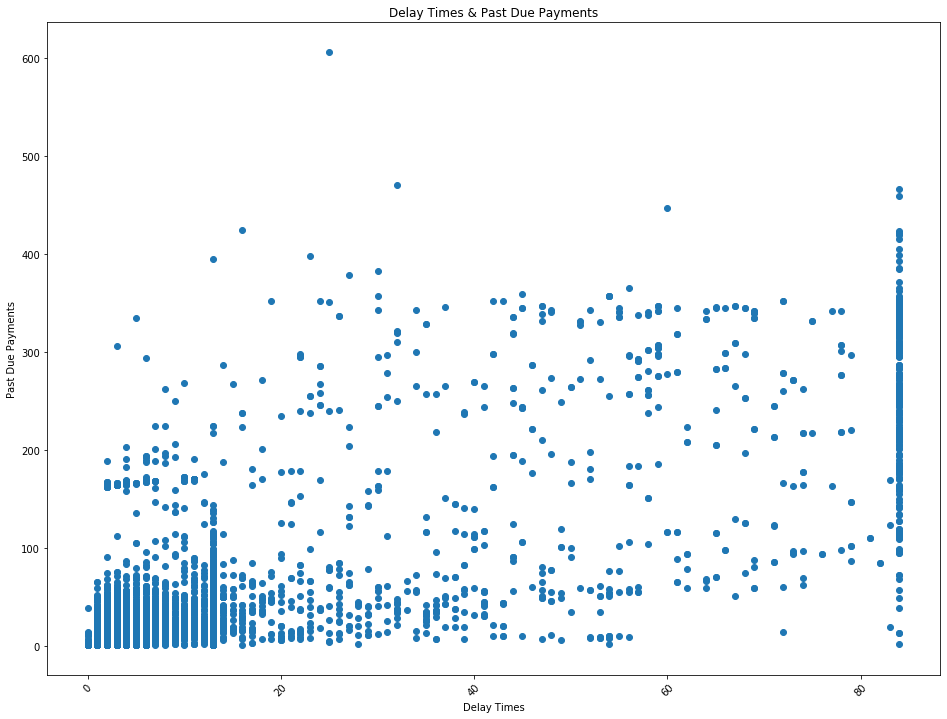

In [11]:
plt.figure(figsize=(16, 12))
plt.scatter(data_person.loc[data_person['Fraud'] == 1].TIMES_PAST_DUE, data_person.loc[data_person['Fraud'] == 1].PAST_DUE_PAYMENTS)
plt.title('Delay Times & Past Due Payments')
plt.xlabel('Delay Times')
plt.ylabel('Past Due Payments')
plt.xticks(rotation=45)
plt.show()

## 2.5  Length of Credit (Credit Update time- Credit Opening time) related to Fraud
### 2.5.1 Calculate Length of Credit

In [12]:
data_person.CREDIT_OPEN_DATE=data_person.CREDIT_OPEN_DATE.fillna(0)
data_person.DATE_CREDIT_UPDATE=data_person.DATE_CREDIT_UPDATE.fillna(0)

/Users/jiahexu/anaconda2/envs/py3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [20]:
data_person.CREDIT_OPEN_DATE=pd.to_datetime(data_person.CREDIT_OPEN_DATE,format="%d%b%Y:%H:%M:%S")
data_person.DATE_CREDIT_UPDATE=pd.to_datetime(data_person.DATE_CREDIT_UPDATE,format="%d%b%Y:%H:%M:%S")

In [21]:
creditlength_year=round((data_person.DATE_CREDIT_UPDATE-data_person.CREDIT_OPEN_DATE)/np.timedelta64(1, 'Y'))
creditlength_month=round((data_person.DATE_CREDIT_UPDATE-data_person.CREDIT_OPEN_DATE)/np.timedelta64(1, 'M'))
data_person.insert( 0,"Credit_Length_year", creditlength_year, True)
data_person.insert( 1,"Credit_Length_month", creditlength_month, True)

In [22]:
data_person

,Credit_Length_year,Credit_Length_month,Good,Fraud,ID_CREDIT,COUNTRY,ID_EVALUATION,NUMBER_OF_PAYMENTS,REPORTED_PAYMENTS,AMOUNT,...,GENDER,MARITAL_STATUS,CPERSNUMCED,DEPENDENT_COUNT,DEATH_DATE,DATEOFREGISTRATION,IDCOUNTRY,COUNTY_DESC1,COUNTY_DESC2,STATE
0,1.0,9.0,0,1,2273,Mexico,5049,52,39,0,...,Male,S,NaN,0,NaN,08OCT2004:00:00:00,MX,NaN,MERIDA,YUC
1,1.0,15.0,0,1,18625,Mexico,5100,100,65,0,...,Female,NaN,NaN,0,NaN,31JAN2014:00:00:00,MX,HUITZUCO,HUITZUCO DE LOS FIGUEROA,GRO
2,1.0,11.0,0,1,12915,Mexico,5100,80,48,0,...,Male,ND,NaN,0,NaN,07MAR2011:00:00:00,MX,SANTA LUCIA OCOTLAN,SANTA LUCIA OCOTLAN,OAX
3,1.0,17.0,0,1,18597,Mexico,5100,100,73,0,...,Female,NaN,NaN,0,NaN,31JAN2014:00:00:00,MX,HUITZUCO,HUITZUCO DE LOS FIGUEROA,GRO
4,0.0,4.0,0,1,548,Mexico,5160,16,18,0,...,Female,C,NaN,0,NaN,28SEP2004:00:00:00,MX,NaN,TAMPICO,TAMP
5,0.0,4.0,0,1,12044,Mexico,5160,16,14,0,...,Female,S,NaN,0,NaN,04OCT2010:00:00:00,MX,CUERNAVACA,CUERNAVACA,MOR
6,0.0,4.0,0,1,13107,Mexico,5160,16,13,0,...,Female,D,NaN,0,NaN,18APR2011:00:00:00,MX,PUEBLAZACAPOAXTLA,NaN,PUE
7,0.0,5.0,0,1,4296,Mexico,5180,20,17,0,...,Female,C,NaN,0,NaN,07JUN2006:00:00:00,MX,ATOYAC DE ALVAREZ,ATOYAC DE ALVAREZ,GRO
8,0.0,4.0,0,1,4300,Mexico,5180,20,17,0,...,Female,C,NaN,0,NaN,07JUN2006:00:00:00,MX,ATOYAC DE ALVAREZ,ATOYAC DE ALVAREZ,GRO
9,0.0,4.0,0,1,6106,Mexico,5180,20,21,0,...,NotSet,ND,NaN,0,NaN,10JUL2007:00:00:00,MX,OAXACA,ASUNCION NOCHIXTLAN,OAX


In [23]:
data_person.loc[data_person['Fraud'] == 1].groupby('Credit_Length_year')['Fraud'].count ()

Credit_Length_year
0.0     1773
1.0     3320
2.0      984
3.0      431
4.0      315
5.0      337
6.0      280
7.0      350
8.0      105
9.0       58
10.0      35
11.0      14
12.0      21
13.0      19
14.0      19
15.0       5
16.0      11
17.0       4
18.0       2
19.0       6
20.0       5
21.0       1
22.0       1
23.0       1
26.0       1
27.0       2
29.0       1
30.0       1
31.0       1
34.0       1
38.0       1
70.0       2
Name: Fraud, dtype: int64

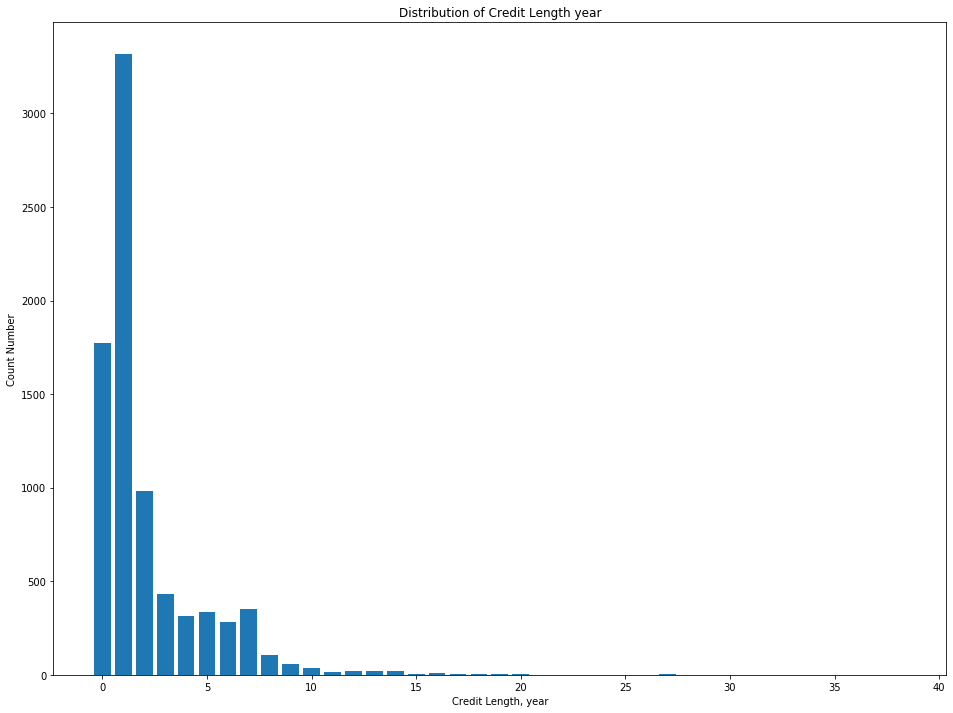

In [24]:
#delete 70 years credit
data_person=data_person[data_person.Credit_Length_year != 70]
# Plot histogram of Credit Length of Year
fig, ax = plt.subplots(figsize=(16, 12))
ax.bar(data_person.loc[data_person['Fraud'] == 1].groupby('Credit_Length_year')['Fraud'].count ().index,data_person.loc[data_person['Fraud'] == 1].groupby('Credit_Length_year')['Fraud'].count ())
ax.set_ylabel('Count Number')
ax.set_xlabel('Credit Length, year')
ax.set_title('Distribution of Credit Length year')
plt.show()

In [26]:
data_person.loc[data_person['Fraud'] == 1].groupby('Credit_Length_month')['Fraud'].count ()

Credit_Length_month
1.0       29
2.0       66
3.0      169
4.0      850
5.0      479
6.0      341
7.0      276
8.0      226
9.0      259
10.0     279
11.0     295
12.0     419
13.0     295
14.0     369
15.0     279
16.0     224
17.0     153
18.0     236
19.0     148
20.0      88
21.0      84
22.0      83
23.0      78
24.0      84
25.0      37
26.0      58
27.0      48
28.0      54
29.0      43
30.0      48
        ... 
193.0      1
194.0      1
195.0      2
196.0      1
197.0      1
199.0      1
201.0      1
204.0      1
206.0      1
212.0      1
213.0      1
224.0      1
225.0      2
229.0      2
230.0      1
238.0      1
239.0      1
240.0      1
241.0      2
247.0      1
264.0      1
278.0      1
310.0      1
318.0      1
326.0      1
352.0      1
359.0      1
369.0      1
414.0      1
461.0      1
Name: Fraud, Length: 197, dtype: int64

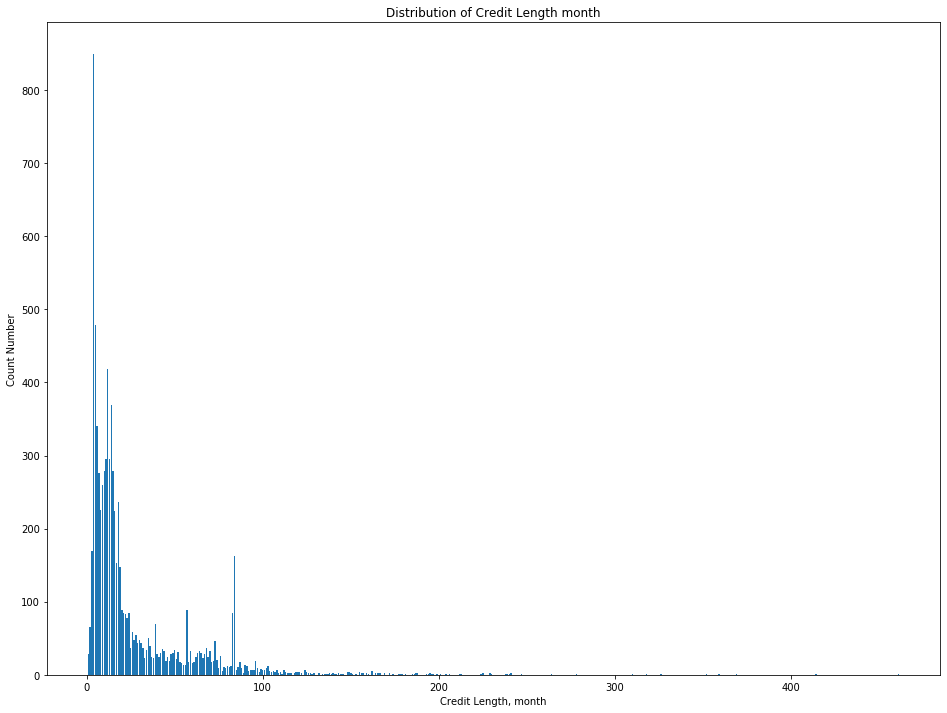

In [25]:
# Plot histogram of Credit Length of Days
fig, ax = plt.subplots(figsize=(16, 12))
ax.bar(data_person.loc[data_person['Fraud'] == 1].groupby('Credit_Length_month')['Fraud'].count ().index,data_person.loc[data_person['Fraud'] == 1].groupby('Credit_Length_month')['Fraud'].count ())
ax.set_ylabel('Count Number')
ax.set_xlabel('Credit Length, month')
ax.set_title('Distribution of Credit Length month')
plt.show()

## 2.6  Length of Credit (Credit Update time- Credit Opening time) related to Past Due Payment

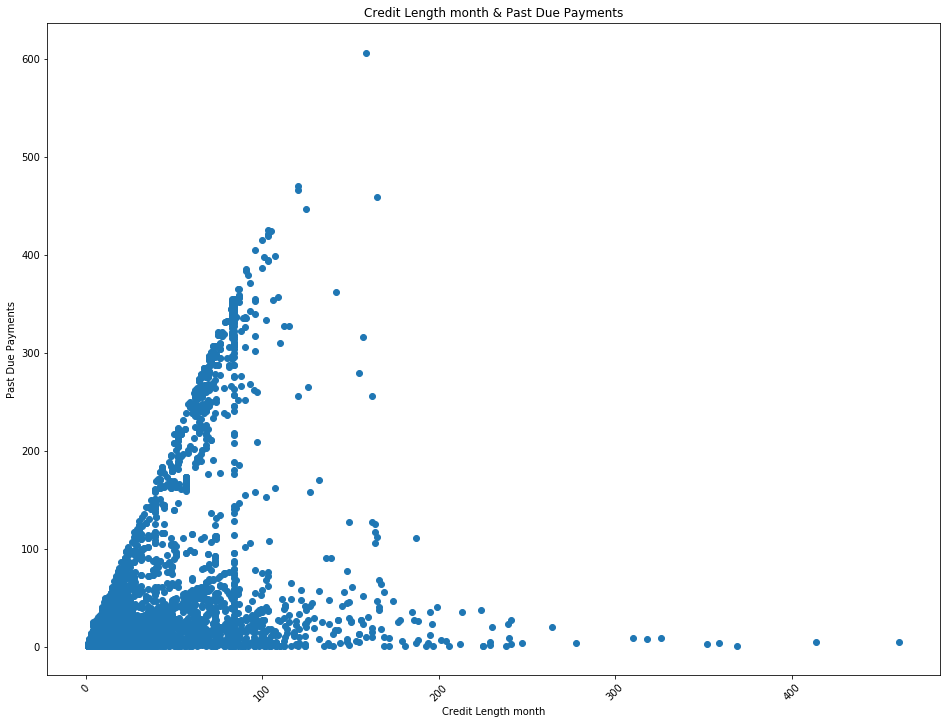

In [27]:
plt.figure(figsize=(16, 12))
plt.scatter(data_person.loc[data_person['Fraud'] == 1].Credit_Length_month, data_person.loc[data_person['Fraud'] == 1].PAST_DUE_PAYMENTS)
plt.title('Credit Length month & Past Due Payments')
plt.xlabel('Credit Length month')
plt.ylabel('Past Due Payments')
plt.xticks(rotation=45)
plt.show()

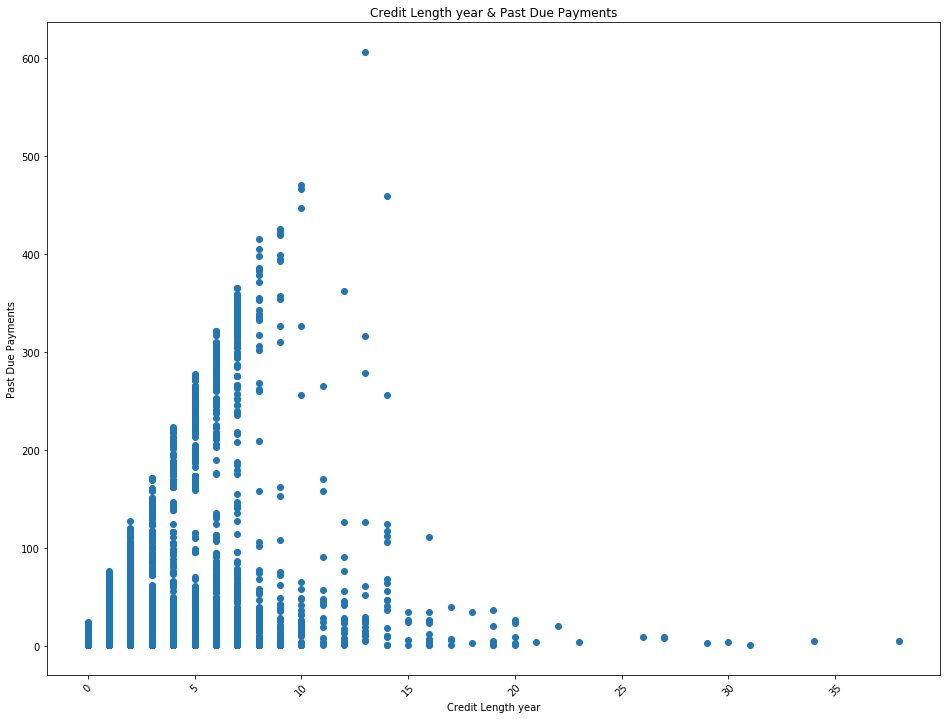

In [28]:
plt.figure(figsize=(16, 12))
plt.scatter(data_person.loc[data_person['Fraud'] == 1].Credit_Length_year, data_person.loc[data_person['Fraud'] == 1].PAST_DUE_PAYMENTS)
plt.title('Credit Length year & Past Due Payments')
plt.xlabel('Credit Length year')
plt.ylabel('Past Due Payments')
plt.xticks(rotation=45)
plt.show()

## 2.7  AMOUNT_LOANED related to  Past due Payment

In [32]:
data_person.loc[data_person['Fraud'] == 1].AMOUNT_LOANED.describe()

count    8.105000e+03
mean     1.369613e+04
std      9.717716e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+03
max      3.974000e+06
Name: AMOUNT_LOANED, dtype: float64

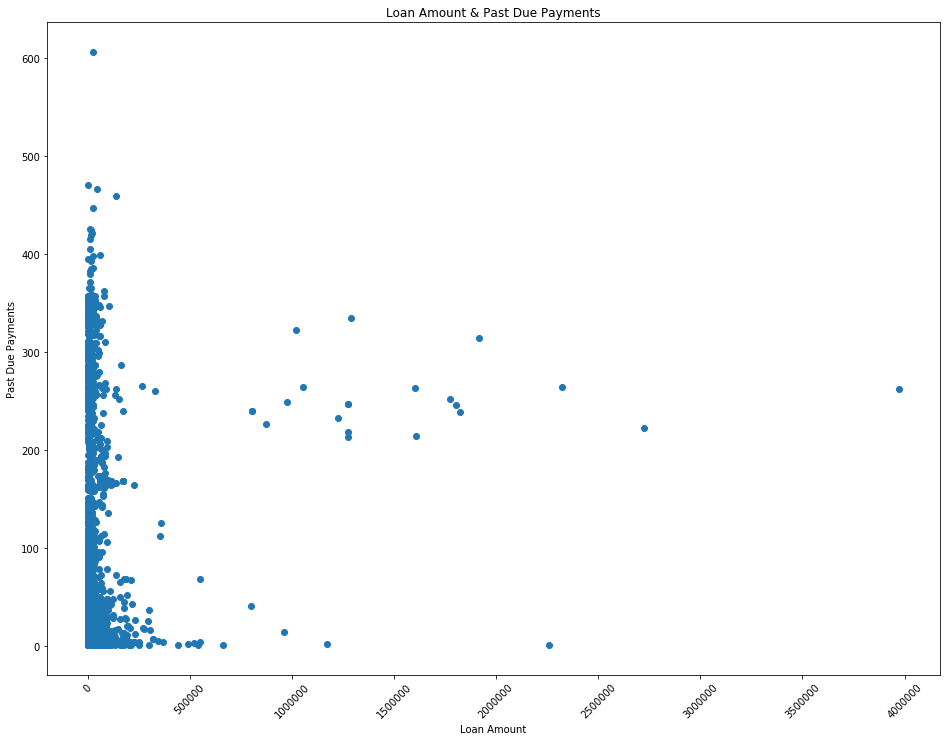

In [31]:
plt.figure(figsize=(16, 12))
plt.scatter(data_person.loc[data_person['Fraud'] == 1].AMOUNT_LOANED, data_person.loc[data_person['Fraud'] == 1].PAST_DUE_PAYMENTS)
plt.title('Loan Amount & Past Due Payments')
plt.xlabel('Loan Amount')
plt.ylabel('Past Due Payments')
plt.xticks(rotation=45)
plt.show()

## 2.8  OUTSTANDING_BALANCE related to  Past due Payment

In [42]:
data_person.loc[data_person['Fraud'] == 1].OUTSTANDING_BALANCE.describe()

count    8.104000e+03
mean     2.526861e+04
std      1.223437e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.975000e+02
max      2.207298e+06
Name: OUTSTANDING_BALANCE, dtype: float64

In [39]:
# remove the max value
data_person=data_person[data_person.OUTSTANDING_BALANCE != 10703863]


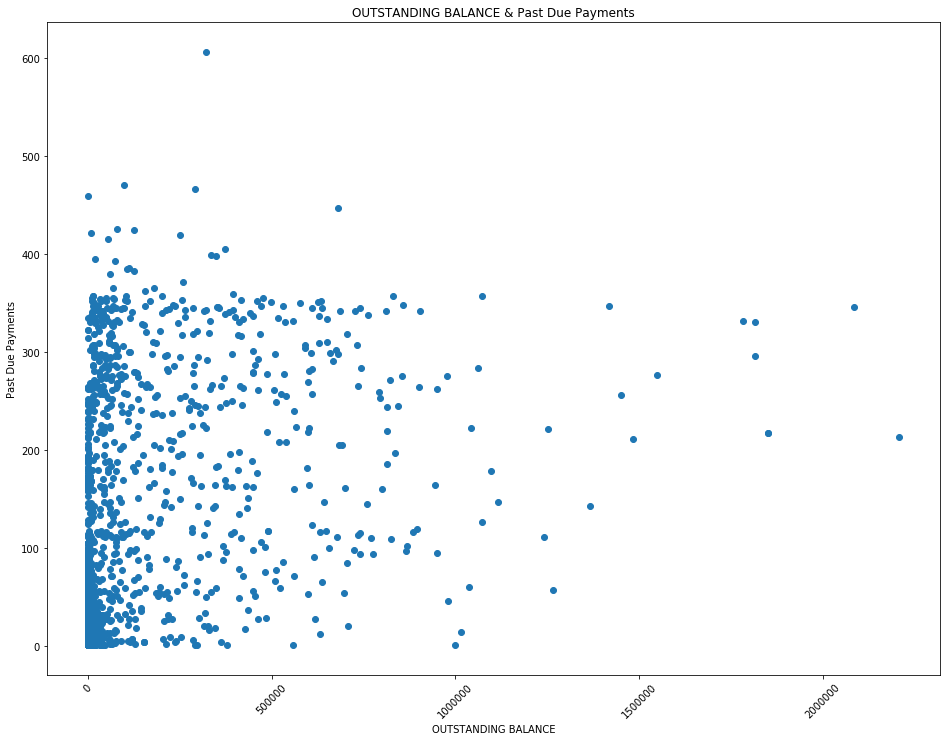

In [40]:
plt.figure(figsize=(16, 12))
plt.scatter(data_person.loc[data_person['Fraud'] == 1].OUTSTANDING_BALANCE, data_person.loc[data_person['Fraud'] == 1].PAST_DUE_PAYMENTS)
plt.title('OUTSTANDING BALANCE & Past Due Payments')
plt.xlabel('OUTSTANDING BALANCE')
plt.ylabel('Past Due Payments')
plt.xticks(rotation=45)
plt.show()

## 2.9  Age related to  Fraud 

In [43]:
data_person.loc[data_person['Fraud'] == 1].AGE.describe()

count    8104.000000
mean       44.437192
std        12.666193
min        20.000000
25%        35.000000
50%        43.000000
75%        53.000000
max       119.000000
Name: AGE, dtype: float64

In [44]:
# Remove 119 
data_person=data_person[data_person.AGE != 119]

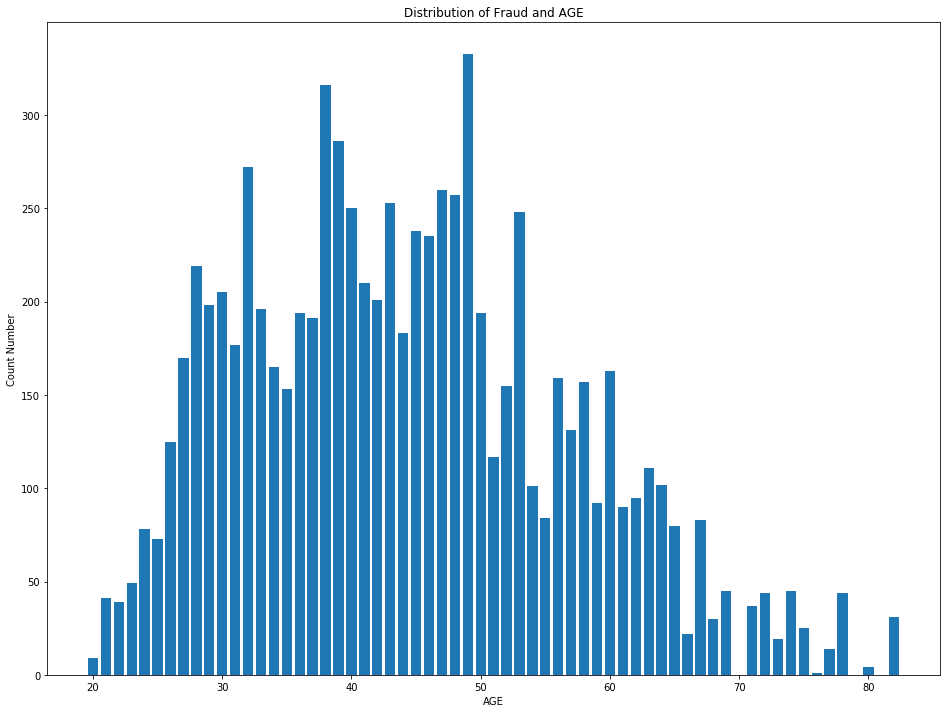

In [50]:
# Plot histogram of Delay times 
fig, ax = plt.subplots(figsize=(16, 12))
ax.bar(data_person.loc[data_person['Fraud'] == 1].groupby('AGE')['Fraud'].count().index,data_person.loc[data_person['Fraud'] == 1].groupby('AGE')['Fraud'].count())
ax.set_ylabel('Count Number')
ax.set_xlabel('AGE')
ax.set_title('Distribution of Fraud and AGE')
plt.show()

## 2.10  Age related to  Past Due Payments

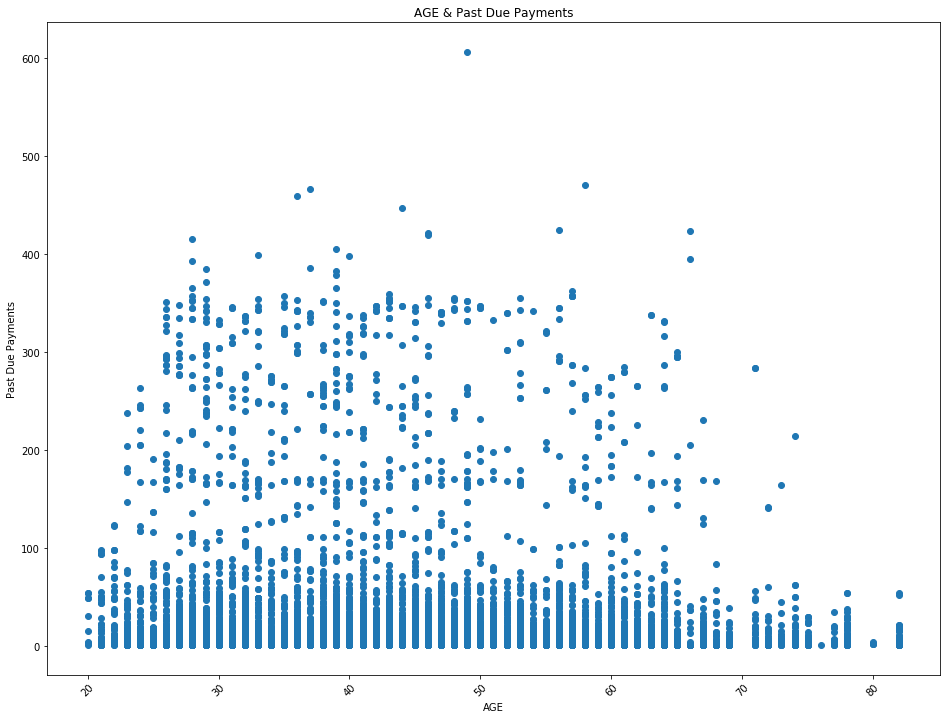

In [51]:
plt.figure(figsize=(16, 12))
plt.scatter(data_person.loc[data_person['Fraud'] == 1].AGE, data_person.loc[data_person['Fraud'] == 1].PAST_DUE_PAYMENTS)
plt.title('AGE & Past Due Payments')
plt.xlabel('AGE')
plt.ylabel('Past Due Payments')
plt.xticks(rotation=45)
plt.show()

## 2.11 State related to  Fraud 

In [112]:
data_person.loc[data_person['Fraud'] == 1].groupby('STATE')['Fraud'].count()

STATE
AGS       35
BC        77
BCS       42
CAMP     121
CDMX      27
CHIH      87
CHIS     223
COAH     210
COL       16
DF       645
DGO       86
GRO      399
GTO      287
HGO      334
JAL      315
MEX     1120
MICH     259
MOR      122
NAY       43
NL       235
OAX      367
PUE      468
QRO      203
QROO      65
SIN      227
SLP      286
SON      135
TAB       90
TAMP     250
TLAX      83
VER     1122
YUC      114
ZAC        6
Name: Fraud, dtype: int64

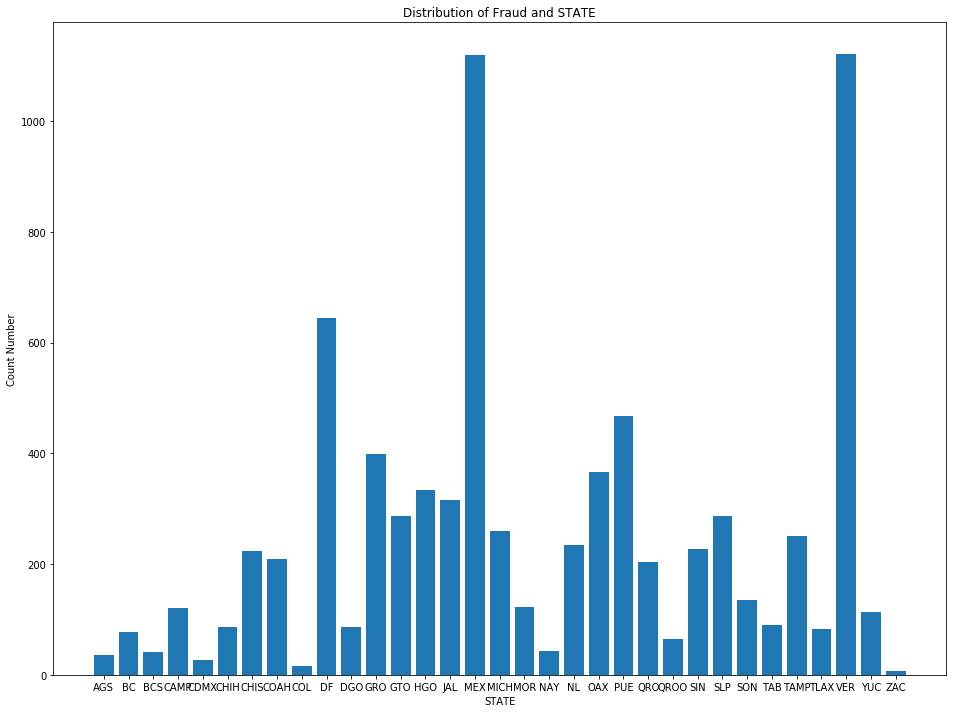

In [54]:
# Plot histogram of State 
fig, ax = plt.subplots(figsize=(16, 12))
ax.bar(data_person.loc[data_person['Fraud'] == 1].groupby('STATE')['Fraud'].count().index,data_person.loc[data_person['Fraud'] == 1].groupby('STATE')['Fraud'].count())
ax.set_ylabel('Count Number')
ax.set_xlabel('STATE')
ax.set_title('Distribution of Fraud and STATE')
plt.show()

## 2.12  State related to  Past Due Payments 

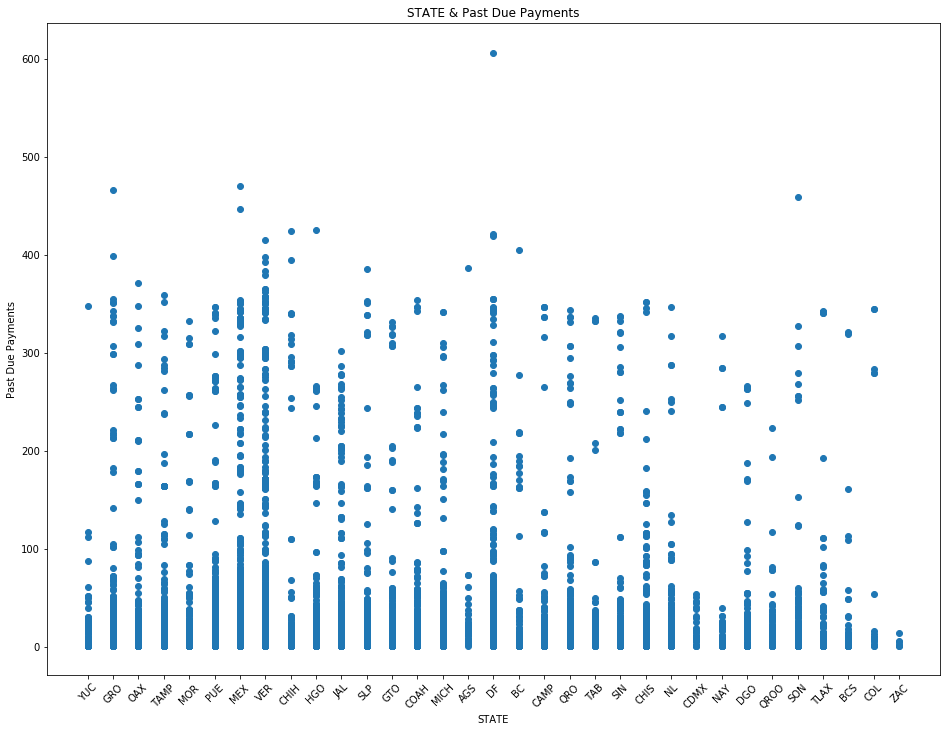

In [55]:
plt.figure(figsize=(16, 12))
plt.scatter(data_person.loc[data_person['Fraud'] == 1].STATE, data_person.loc[data_person['Fraud'] == 1].PAST_DUE_PAYMENTS)
plt.title('STATE & Past Due Payments')
plt.xlabel('STATE')
plt.ylabel('Past Due Payments')
plt.xticks(rotation=45)
plt.show()

## Part3:  Build WOE Model based on Fraud data
$$WOE_i=-ln(\frac{P_{good}}{P_{fraud}})=-ln(\frac{G_i/G_{Total}}{F_i/F_{Total}}),\ i=1,2,...,N$$
### where G_i is the number of good samples in the i group of a variable, and G_Total is the sum of the number of good samples in all groups of a variable.

### F_i is the number of fraud samples in the ith group of a variable, and F_Total is the sum of the number of fraud samples in all groups of a variable.


## Build IV Model based on Fraud data and WOE 
### The information of the i-th group of a variable
$$IV_i=(P_{fraud}-P_{good})*WOE_i,\ i=1,2,...,N$$

### Total information for a variable
$$IV=\sum IV_i,\ i=1,2,...,N$$



In [56]:
def woewoe(b):
    b["fraud_ratio"]=b.iloc[:,1]/(b.iloc[:,0]+b.iloc[:,1]) 
    b["Total_amount"]=(b.iloc[:,0]+b.iloc[:,1])    
    b["fraud_occupancy"]=b.iloc[:,1]/b.iloc[:,1].sum()
    b["good_occupancy"]=b.iloc[:,0]/b.iloc[:,0].sum()
    b["WOE"]=np.log((b["good_occupancy"]/b["fraud_occupancy"]))*(-1)
    b["bin_IV"]=b["WOE"]*(b["fraud_occupancy"]-b["good_occupancy"])
    b["IV"]=b["bin_IV"].sum()
    return b

## Part 4: Cut each factor related to Fraud into different group based on their distribution 

## 4.1 Delay Times
#### groups=["0","1","1-3","3-12","12-32","above"]


In [76]:
bins=[-0.1,0,1,3,12,32,max(data_person.TIMES_PAST_DUE)+1]
labels=["0","1","1-3","3-12","12-32","above"]
data_person["past time cutting"]=pd.cut(data_person.TIMES_PAST_DUE,bins=bins,labels=labels)#cutting past due payments
revo_groupby=data_person.pivot_table(values=["Good","Fraud"],index=["past time cutting"],aggfunc=[np.sum])
woewoe(revo_groupby)

sum        fraud_ratio Total_amount fraud_occupancy  \
                  Fraud   Good                                            
past time cutting                                                         
0                    33  12115    0.997284        12148        0.993929   
1                  2942     44    0.014735         2986        0.003610   
1-3                1672      6    0.003576         1678        0.000492   
3-12               1591     13    0.008105         1604        0.001067   
12-32              1191     10    0.008326         1201        0.000820   
above               670      1    0.001490          671        0.000082   

                  good_occupancy       WOE    bin_IV         IV  
                                                                 
past time cutting                                                
0                       0.004075  5.496899  5.441129  10.692756  
1                       0.363255 -4.611449  1.658484  10.692756  
1-3                     0.206445 -6.038810  1.243711  10.692756  
3-12                    0.196444 -5.215962  1.019081  10.692756  
12-32                   0.147055 -5.188757  0.758777  10.692756  
above                   0.082726 -6.916071  0.571573  10.692756

## 4.2 Length of Credit
#### groups=["0-6","6-12","12-18","18-24","above"]


In [82]:
bins=[-0.1,6,12,18,24,max(data_person.Credit_Length_month)+1]
labels=["0-6","6-12","12-18","18-24","above"]
data_person["credit length cutting"]=pd.cut(data_person.Credit_Length_month,bins=bins,labels=labels)#cutting past due payments
revo_groupby=data_person.pivot_table(values=["Good","Fraud"],index=["credit length cutting"],aggfunc=[np.sum])
woewoe(revo_groupby)

sum       fraud_ratio Total_amount fraud_occupancy  \
                      Fraud  Good                                            
credit length cutting                                                        
0-6                    1930  7725    0.800104         9655        0.633768   
6-12                   1754  1666    0.487135         3420        0.136681   
12-18                  1556  1141    0.423063         2697        0.093609   
18-24                   565   392    0.409613          957        0.032160   
above                  2294  1265    0.355437         3559        0.103782   

                      good_occupancy       WOE    bin_IV        IV  
                                                                    
credit length cutting                                               
0-6                         0.238301  0.978149  0.386826  0.703729  
6-12                        0.216570 -0.460267  0.036770  0.703729  
12-18                       0.192122 -0.719007  0.070832  0.703729  
18-24                       0.069762 -0.774357  0.029117  0.703729  
above                       0.283245 -1.004018  0.180184  0.703729

## 4.3 AMOUNT_LOANED 
#### groups=["0-10000","above"]

In [92]:
bins=[-0.1,10000,max(data_person.AMOUNT_LOANED)+1]
labels=["0-10000","above"]
data_person["amount loaned cutting"]=pd.cut(data_person.AMOUNT_LOANED,bins=bins,labels=labels)#cutting past due payments
revo_groupby=data_person.pivot_table(values=["Good","Fraud"],index=["amount loaned cutting"],aggfunc=[np.sum])
woewoe(revo_groupby)

sum        fraud_ratio Total_amount fraud_occupancy  \
                      Fraud   Good                                            
amount loaned cutting                                                         
0-10000                6577  10445    0.613618        17022         0.85692   
above                  1522   1744    0.533987         3266         0.14308   

                      good_occupancy       WOE    bin_IV        IV  
                                                                    
amount loaned cutting                                               
0-10000                     0.812076  0.053751  0.002410  0.014637  
above                       0.187924 -0.272637  0.012226  0.014637

## 4.4 OUTSTANDING_BALANCE 
#### groups=["0","above"]

In [99]:
bins=[-0.1,0,max(data_person.OUTSTANDING_BALANCE)+1]
labels=["0","above"]
data_person["OUTSTANDING BALANCE cutting"]=pd.cut(data_person.OUTSTANDING_BALANCE,bins=bins,labels=labels)#cutting past due payments
revo_groupby=data_person.pivot_table(values=["Good","Fraud"],index=["OUTSTANDING BALANCE cutting"],aggfunc=[np.sum])
woewoe(revo_groupby)

sum        fraud_ratio Total_amount  \
                            Fraud   Good                            
OUTSTANDING BALANCE cutting                                         
0                            5747  11194    0.660764        16941   
above                        2352    995    0.297281         3347   

                            fraud_occupancy good_occupancy       WOE  \
                                                                       
OUTSTANDING BALANCE cutting                                            
0                                  0.918369       0.709594  0.257907   
above                              0.081631       0.290406 -1.269072   

                               bin_IV        IV  
                                                 
OUTSTANDING BALANCE cutting                      
0                            0.053845  0.318795  
above                        0.264951  0.318795

## 4.5 Age

In [108]:
bins=[-0.1,25,50,65,max(data_person.AGE)+1]
labels=["0-25","25-50","50-65","above"]
data_person["AGE cutting"]=pd.cut(data_person.AGE,bins=bins,labels=labels)#cutting past due payments
revo_groupby=data_person.pivot_table(values=["Good","Fraud"],index=["AGE cutting"],aggfunc=[np.sum])
woewoe(revo_groupby)

sum       fraud_ratio Total_amount fraud_occupancy  \
            Fraud  Good                                            
AGE cutting                                                        
0-25          289   356    0.551938          645        0.029207   
25-50        5481  7940    0.591610        13421        0.651407   
50-65        1885  3378    0.641839         5263        0.277135   
above         444   515    0.537018          959        0.042251   

            good_occupancy       WOE    bin_IV        IV  
                                                          
AGE cutting                                               
0-25              0.035683 -0.200289  0.001297  0.013287  
25-50             0.676750 -0.038168  0.000967  0.013287  
50-65             0.232745  0.174563  0.007749  0.013287  
above             0.054822 -0.260451  0.003274  0.013287

## 4.6 State

In [115]:
data_person["State cutting"]=data_person.STATE#cutting past due payments
revo_groupby=data_person.pivot_table(values=["Good","Fraud"],index=["State cutting"],aggfunc=[np.sum])
woewoe(revo_groupby)

sum       fraud_ratio Total_amount fraud_occupancy  \
              Fraud  Good                                            
State cutting                                                        
AGS              35    53    0.602273           88        0.004348   
BC               77   245    0.760870          322        0.020100   
BCS              42    72    0.631579          114        0.005907   
CAMP            121   550    0.819672          671        0.045123   
CDMX             27    18    0.400000           45        0.001477   
CHIH             87   159    0.646341          246        0.013045   
CHIS            223   218    0.494331          441        0.017885   
COAH            210   301    0.589041          511        0.024694   
COL              16     8    0.333333           24        0.000656   
DF              645  1014    0.611212         1659        0.083190   
DGO              86    75    0.465839          161        0.006153   
GRO             399   786    0.663291         1185        0.064484   
GTO             287   387    0.574184          674        0.031750   
HGO             334   612    0.646934          946        0.050209   
JAL             315   484    0.605757          799        0.039708   
MEX            1120  1538    0.578631         2658        0.126179   
MICH            259   369    0.587580          628        0.030273   
MOR             122   196    0.616352          318        0.016080   
NAY              43    43    0.500000           86        0.003528   
NL              235   362    0.606365          597        0.029699   
OAX             367   442    0.546354          809        0.036262   
PUE             468   722    0.606723         1190        0.059234   
QRO             203   224    0.524590          427        0.018377   
QROO             65    49    0.429825          114        0.004020   
SIN             227   327    0.590253          554        0.026827   
SLP             286   296    0.508591          582        0.024284   
SON             135   123    0.476744          258        0.010091   
TAB              90   202    0.691781          292        0.016572   
TAMP            250   391    0.609984          641        0.032078   
TLAX             83   128    0.606635          211        0.010501   
VER            1122  1566    0.582589         2688        0.128476   
YUC             114   215    0.653495          329        0.017639   
ZAC               6    14    0.700000           20        0.001149   

              good_occupancy       WOE        bin_IV        IV  
                                                                
State cutting                                                   
AGS                 0.004322  0.006151  1.639834e-07  0.078269  
BC                  0.009507  0.748659  7.930358e-03  0.078269  
BCS                 0.005186  0.130203  9.389472e-05  0.078269  
CAMP                0.014940  1.105334  3.336180e-02  0.078269  
CDMX                0.003334 -0.814258  1.512081e-03  0.078269  
CHIH                0.010742  0.194203  4.471483e-04  0.078269  
CHIS                0.027534 -0.431470  4.163377e-03  0.078269  
COAH                0.025929 -0.048791  6.024321e-05  0.078269  
COL                 0.001976 -1.101940  1.453705e-03  0.078269  
DF                  0.079639  0.043615  1.548448e-04  0.078269  
DGO                 0.010619 -0.545652  2.436614e-03  0.078269  
GRO                 0.049265  0.269202  4.096994e-03  0.078269  
GTO                 0.035436 -0.109851  4.049690e-04  0.078269  
HGO                 0.041240  0.196798  1.765189e-03  0.078269  
JAL                 0.038894  0.020719  1.687026e-05  0.078269  
MEX                 0.138289 -0.091639  1.109689e-03  0.078269  
MICH                0.031979 -0.054825  9.353425e-05  0.078269  
MOR                 0.015064  0.065300  6.637672e-05  0.078269  
NAY                 0.005309 -0.408793  7.282761e-04  0.078269  
NL                  0.029016  0.023265  1.588982e-05  0.078269  


# Calculate total payments they need to pay since opening card
### 1. Build dataframe named data 
#### 1.1 TYPE_OF_CUSTOMER2, PAST_DUE_PAYMENTS, FREQUENCY_CODE, CREDIT_OPEN_DATE, DATE_CREDIT_UPDATE
#### 1.2 Calulate total days from opening card to update card
#### 1.3 Calulate total times they need to pay based on frequence payments

In [102]:
# Build dataframe contains type of customer, past due payments, frequency, credit opening, credit update
data=pd.DataFrame()
data.insert(0, "ID_CREDIT", integrate_data.ID_CREDIT, True)
data.insert(1, "TYPE_OF_CUSTOMER2", integrate_data.TYPE_OF_CUSTOMER2, True)
data.insert(2, "PAST_DUE_PAYMENTS", integrate_data.PAST_DUE_PAYMENTS, True)
data.insert(3, "FREQUENCY_CODE", integrate_data.FREQUENCY_CODE, True)
data.insert(4, "FREQUENCY_DESC", integrate_data.FREQUENCY_DESC, True)
data.insert(5, "CREDIT_OPEN_DATE", integrate_data.CREDIT_OPEN_DATE, True)
data.insert(6, "DATE_CREDIT_UPDATE", integrate_data.DATE_CREDIT_UPDATE, True)
date_cols = [col for col in data.columns if 'DATE' in col]
# Datetime formate
data[date_cols] = pd.to_datetime(data[date_cols].stack(),format="%d%b%Y:%H:%M:%S").unstack()
#Only keep person customer
data=data.loc[data['TYPE_OF_CUSTOMER2'] == 'PF']
data = data.drop(columns="TYPE_OF_CUSTOMER2")

In [103]:
# This function translate frequency code to datatime formate
# After run this function, the result is a list and contains unit corresponding to frequency
def translateunit(frequency):
    c=[]
    for _, value in frequency.items():
        if value=='M'or value=='R'or value=='U'or value=='D':
            c.append(np.timedelta64(1, 'M'))
        elif value=='Q'or value=='C':
            c.append(np.timedelta64(2, 'W'))
        elif value=='S':
            c.append(np.timedelta64(1, 'W'))
        elif value=='T':
            c.append(np.timedelta64(3, 'W'))
        elif value=='A':
            c.append(np.timedelta64(1, 'Y'))
        elif value=='B':
            c.append(np.timedelta64(2, 'M'))
    return c

In [104]:
# calculate total payment times
paymentimes=(data.DATE_CREDIT_UPDATE-data.CREDIT_OPEN_DATE)/translateunit(data.FREQUENCY_CODE)
# calculate whether total payment times > past due payments (True, False)
countgreater=paymentimes> data.PAST_DUE_PAYMENTS
# Add payments, countgreater to dataframe
data.insert(1, "Totoal_times", paymentimes, True)
data.insert(3, "Boolean", countgreater, True)
# Save data frame to execel name Data_related
data.to_excel("./Date_related.xlsx")

In [99]:
coun.value_counts()
data.FREQUENCY_CODE.value_counts()

In [39]:
# Build dataframe contains type of customer, past due payments, state, zipcode
dataregion=pd.DataFrame()
dataregion.insert(0, "ID_CREDIT", integrate_data.ID_CREDIT, True)
dataregion.insert(1, "Good", integrate_data.Good, True)
dataregion.insert(2, "Fraud", integrate_data.Fraud, True)
dataregion.insert(1, "TYPE_OF_CUSTOMER2", integrate_data.TYPE_OF_CUSTOMER2, True)
dataregion.insert(3, "ZIPCODE", integrate_data.ZIPCODE, True)
dataregion.insert(4, "STATE", integrate_data.STATE, True)
#Only keep person customer
dataregion=dataregion.loc[dataregion['TYPE_OF_CUSTOMER2'] == 'PF']
dataregion = dataregion.drop(columns="TYPE_OF_CUSTOMER2")
dataregion_good=dataregion.loc[dataregion['Good'] == 1]
dataregion_fraud=dataregion.loc[dataregion['Fraud'] == 1]

In [45]:
f=dataregion_fraud.groupby('STATE')['Fraud'].count()
g=dataregion_good.groupby('STATE')['Good'].count()

In [47]:
frame=pd.DataFrame()
frame.insert(0, "Good", g, True)
frame.insert(1, "Fraud", f, True)

In [51]:
woewoe(frame)

,Good,Fraud,fraud_ratio,Total_amount,fraud_occupancy,good_occupancy,WOE,bin_IV,IV
STATE,,,,,,,,,
AGS,53,35,0.397727,88,0.004317,0.004347,-0.006892,2.057609e-07,0.078166
BC,245,77,0.239130,322,0.009498,0.020095,-0.749401,7.941534e-03,0.078166
BCS,72,46,0.389831,118,0.005674,0.005906,-0.039973,9.249782e-06,0.078166
CAMP,550,121,0.180328,671,0.014925,0.045112,-1.106076,3.338819e-02,0.078166
CDMX,18,27,0.600000,45,0.003330,0.001476,0.813517,1.508324e-03,0.078166
CHIH,159,87,0.353659,246,0.010731,0.013041,-0.194944,4.502956e-04,0.078166
CHIS,218,223,0.505669,441,0.027507,0.017881,0.430729,4.146418e-03,0.078166
COAH,301,210,0.410959,511,0.025904,0.024688,0.048049,5.839056e-05,0.078166
COL,8,16,0.666667,24,0.001974,0.000656,1.101199,1.450759e-03,0.078166


# Find Relation between Past Due Payment and Region
## Plot scatter find any relation between state, zipcode, pastdue

In [3]:
# Build dataframe contains type of customer, past due payments, state, zipcode
dataregion=pd.DataFrame()
dataregion.insert(0, "ID_CREDIT", integrate_data.ID_CREDIT, True)
dataregion.insert(1, "TYPE_OF_CUSTOMER2", integrate_data.TYPE_OF_CUSTOMER2, True)
dataregion.insert(2, "PAST_DUE_PAYMENTS", integrate_data.PAST_DUE_PAYMENTS, True)
dataregion.insert(3, "ZIPCODE", integrate_data.ZIPCODE, True)
dataregion.insert(4, "STATE", integrate_data.STATE, True)
#Only keep person customer
dataregion=dataregion.loc[dataregion['TYPE_OF_CUSTOMER2'] == 'PF']
dataregion = dataregion.drop(columns="TYPE_OF_CUSTOMER2")

In [88]:
DF.groupby('ZIPCODE')['PAST_DUE_PAYMENTS'].describe()

,count,mean,std,min,25%,50%,75%,max
ZIPCODE,,,,,,,,
1140,13.0,83.615385,101.002094,0.0,2.00,46.0,139.00,355.0
1210,18.0,9.388889,13.890915,0.0,0.25,1.5,9.50,38.0
1219,22.0,23.227273,58.098383,0.0,0.50,4.0,10.25,209.0
1296,11.0,71.545455,122.542534,0.0,0.00,0.0,129.50,264.0
1298,57.0,6.122807,11.178855,0.0,0.00,1.0,7.00,54.0
1650,6.0,35.833333,33.259084,1.0,6.00,38.5,65.00,68.0
1860,4.0,88.750000,172.176992,0.0,3.00,4.0,89.75,347.0
2050,4.0,22.500000,30.182777,0.0,1.50,12.5,33.50,65.0
2060,32.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [ ]:
# Build dataframe contains type of customer, past due payments, state, zipcode
dataregion=pd.DataFrame()
dataregion.insert(0, "ID_CREDIT", integrate_data.ID_CREDIT, True)
dataregion.insert(1, "Good", integrate_data.Good, True)
dataregion.insert(2, "Fraud", integrate_data.Fraud, True)
dataregion.insert(1, "TYPE_OF_CUSTOMER2", integrate_data.TYPE_OF_CUSTOMER2, True)
dataregion.insert(3, "ZIPCODE", integrate_data.ZIPCODE, True)
dataregion.insert(4, "STATE", integrate_data.STATE, True)
#Only keep person customer
dataregion=dataregion.loc[dataregion['TYPE_OF_CUSTOMER2'] == 'PF']
dataregion = dataregion.drop(columns="TYPE_OF_CUSTOMER2")
dataregion_good=dataregion.loc[dataregion['Good'] == 1]
dataregion_fraud=dataregion.loc[dataregion['Fraud'] == 1]

In [4]:
statedate=dataregion.groupby('STATE')['PAST_DUE_PAYMENTS'].describe().sort_values('mean')


In [5]:
statedate

,count,mean,std,min,25%,50%,75%,max
STATE,,,,,,,,
ZAC,20.0,1.450000,3.410124,0.0,0.0,0.0,1.00,14.0
YUC,329.0,5.939210,23.273610,0.0,0.0,0.0,2.00,348.0
CAMP,671.0,7.099851,35.969894,0.0,0.0,0.0,0.00,347.0
HGO,947.0,9.026399,34.262701,0.0,0.0,0.0,2.00,425.0
NL,597.0,9.386935,34.280956,0.0,0.0,0.0,4.00,347.0
TAB,292.0,9.431507,38.629513,0.0,0.0,0.0,3.00,335.0
GRO,1185.0,9.858228,42.873185,0.0,0.0,0.0,2.00,466.0
GTO,674.0,10.747774,39.997086,0.0,0.0,0.0,4.00,331.0
OAX,809.0,11.077874,38.223226,0.0,0.0,0.0,6.00,371.0


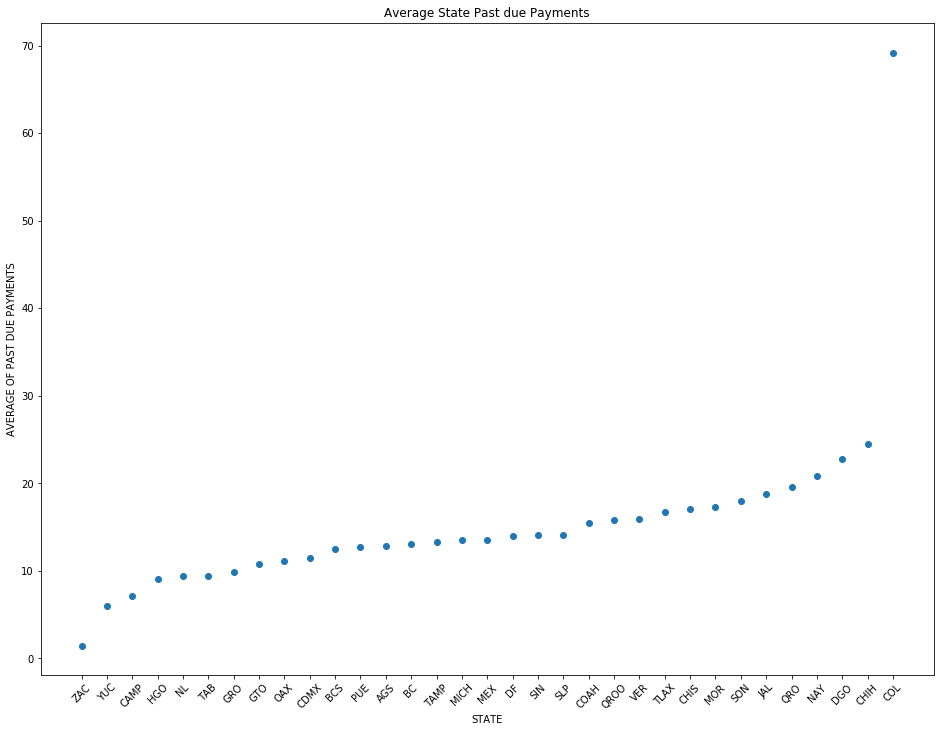

In [15]:
plt.figure(figsize=(16, 12))
plt.scatter(statedate.index, statedate['mean'])
plt.title('Average State Past due Payments')
plt.xlabel('STATE')
plt.ylabel('AVERAGE OF PAST DUE PAYMENTS')
plt.xticks(rotation=45)
plt.show()

#### From above Figure, we can see STATE ZAC has lowest average past payments, STATE COL has highest average past payments.
#### ZAC only contains 20 customes,  COL only contains 24 customes, due to lack of customes, we could analyze these two states later.

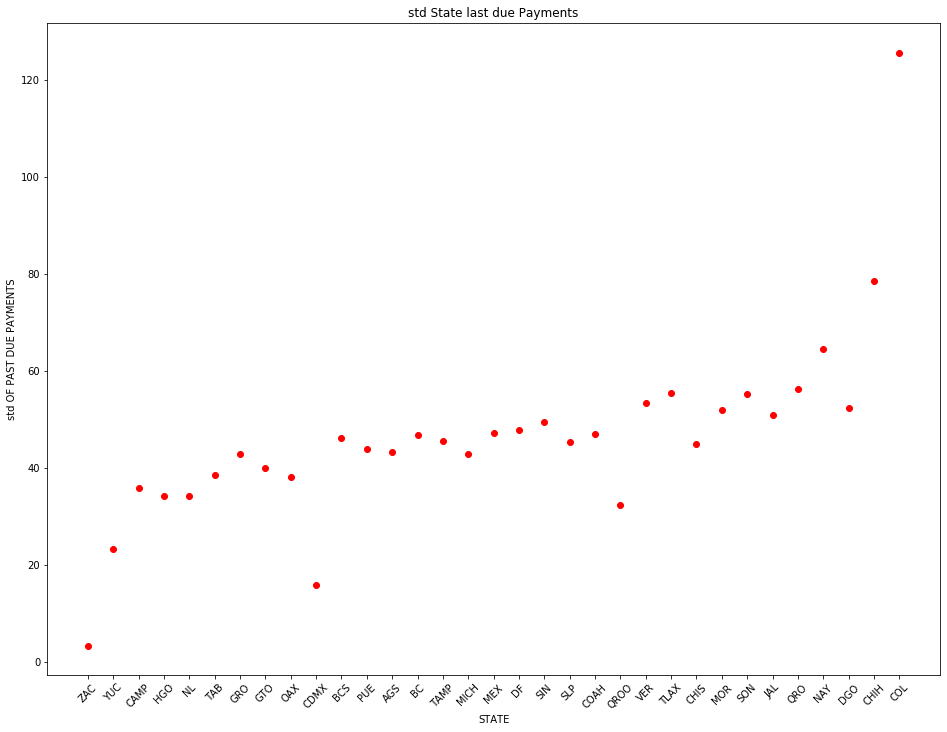

In [18]:
plt.figure(figsize=(16, 12))
plt.scatter(statedate.index, statedate['std'],color='red')
plt.title('std State last due Payments')
plt.xlabel('STATE')
plt.ylabel('std OF PAST DUE PAYMENTS')
plt.xticks(rotation=45)
plt.show()

In [3]:
integrate_data=integrate_data.drop(['DATE_LAST_ZERO', 'UPDATE_TYPE','ID_CREDIT_UPDATE','DEATH_DATE'], axis=1)
date_cols = [col for col in integrate_data.columns if 'DATE' in col]
integrate_data[date_cols] = pd.to_datetime(integrate_data[date_cols].stack(),format="%d%b%Y:%H:%M:%S").unstack()
integrate_data[date_cols].head()

,CREDIT_OPEN_DATE,LAST_PAYMENT_DATE,LAST_PURCHASE_DATE,MAX_LIQUIDITY_DATE,RENEGOTIATED_DATE,CREDIT_PROCESSING_DATE,REGISTRATION_DATE,CUTOFF_DATE,REGISTRATION_DATE.1,DATE_CREDIT_UPDATE,DATE_WORST_DELAY,DATE_REGISTERED_AS_PAST_DUE,DATEOFBIRTH,DATEOFREGISTRATION
0,2016-07-07,2019-11-14,2016-07-07,NaT,2019-12-06,2019-12-06,2016-08-11,2019-11-30,2016-08-11 21:45:46,2019-12-06 09:27:58,NaT,NaT,1960-08-28,2009-04-29
1,2018-06-14,2019-11-14,2018-06-14,NaT,2019-12-06,2019-12-06,2018-07-03,2019-11-30,2018-07-03 13:39:59,2019-12-06 09:27:49,NaT,NaT,1964-07-09,2009-08-07
2,2017-03-21,2019-12-04,2017-03-21,NaT,2019-12-18,2019-12-18,2017-05-22,2019-12-15,2017-05-22 05:01:00,2019-12-18 11:11:32,NaT,NaT,1989-12-07,2014-06-09
3,2014-05-04,2015-07-07,2014-05-04,2015-07-07,2015-07-13,2015-07-13,2014-05-07,2015-07-08,2014-05-07 20:57:00,2015-07-13 07:29:46,2015-07-05,NaT,1981-02-09,2011-01-01
4,2005-12-08,2007-11-21,2005-12-08,2007-11-21,2011-05-18,2011-05-18,2011-05-18,2011-03-31,2011-01-01 01:21:13,2011-05-18 06:34:46,NaT,NaT,1981-02-09,2011-01-01
